In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import EllipticBitcoinDataset
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_dense_adj
from src.dominant import (
    DOMINANTAugmented,
)  # note we're using the custom DOMINANTAugmented class here
from tqdm import tqdm  #
import datetime
import os
import json
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from typing import Dict, Tuple
import numpy as np
from src.loaders import load_elliptic, make_loader
from src.traditional_models import train_traditional_classifier
from main import load_dataset, create_model, create_loader, train_model, test_model
import argparse
import warnings
import yaml

In [2]:
def hyperparameter_loop(parameter, parameter_list, metrics):
    """
    Run a grid search for a hyperparameter
    Args: hyperparameter, hyperparameter list, classification metrics (empty dict)
    Returns: Classification metrics dictionary
    """ 
    for i in range(len(parameter_list)):
        config.update(parameter= parameter_list[i])
        model, device = create_model(data, config)

        train_loader = create_loader(data,batch_size=config["batch_size"], num_neighbors=config["num_neighbors"],use_train_mask=True)

        model, training_metrics = train_model(model,train_loader,learning_rate=config["learning_rate"],device=device,
                    num_epochs=config["num_epochs"],output_directory=config["save_dir"])

        test_metrics = test_model(model,data,device,batch_size=config["batch_size"],num_neighbors=config["num_neighbors"],
                output_directory=config["save_dir"])
        metrics["auc"].append(test_metrics["auc"])
        metrics["accuracy"].append(test_metrics["accuracy"])
        metrics["f1"].append(test_metrics["f1"])
        metrics["precision"].append(test_metrics["precision"])
        metrics["recall"].append(test_metrics["recall"])
    return metrics

def plot_metrics(metrics, para_list, parameter, x_log = False) -> None:
    """
    Plot the classification metrics
    Args:classification metrics
    Returns:None
    """ 
    plt.figure(figsize=(10, 5))
    plt.plot(para_list, metrics["auc"], label="AUC")
    plt.plot(para_list, metrics["f1"], label="F1")
    plt.plot(para_list, metrics["precision"], label="Precision")
    plt.plot(para_list, metrics["recall"], label="Recall")
    plt.xlabel(parameter)
    plt.ylabel("Metrics")
    if x_log:  plt.xscale("log")
    plt.title("Classification Metrics")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:
config = {
            # Model parameters
            "num_layers": 3,
            "hidden_dim": 64,
            "num_heads": 4,
            "dropout": 0.1,
            "backbone": 'gcn',
            "apply_augmentation": False,
            "use_interpolation": False,
            "use_perturbation": False,
            "interpolation_rate": 0.1,
            "feature_noise": 0.05,
            "structure_noise": 0.05,
            "use_adaptive_alpha": False,
            "start_alpha": 0.6,
            "end_alpha": 0.5,
            "use_aggregation": False,
            "aggregation_mean": False,
            "aggregation_max": False,
            # Training parameters
            "batch_size": 2048,
            "num_neighbors": [10, 10],
            "learning_rate": 0.005,
            "num_epochs": 10,
            # Paths for output
            "data_root": "data/elliptic",
            "save_dir": "./saved_models",
        }

#### Number of layers

In [5]:
data = load_dataset(root=config["data_root"])
metrics = {"auc": [], "accuracy": [],"f1": [], "precision": [], "recall": []}

para_change = "num_layers"
para_list = [1, 3, 5, 7]

metrics = hyperparameter_loop(para_change, para_list, metrics)

Using GCN as backbone, with 3 layers.
Epoch 1/10
Avg Batch Loss: 6.230e+02, Avg Batch Attribute Loss: 1.606e+01, Avg Batch Structure Loss: 1.533e+03
Epoch 2/10
Avg Batch Loss: 3.519e+01, Avg Batch Attribute Loss: 1.358e+01, Avg Batch Structure Loss: 6.759e+01
Epoch 3/10
Avg Batch Loss: 1.404e+01, Avg Batch Attribute Loss: 1.285e+01, Avg Batch Structure Loss: 1.582e+01
Epoch 4/10
Avg Batch Loss: 1.074e+01, Avg Batch Attribute Loss: 1.244e+01, Avg Batch Structure Loss: 8.194e+00
Epoch 5/10
Avg Batch Loss: 9.730e+00, Avg Batch Attribute Loss: 1.221e+01, Avg Batch Structure Loss: 6.005e+00
Epoch 6/10
Avg Batch Loss: 9.573e+00, Avg Batch Attribute Loss: 1.207e+01, Avg Batch Structure Loss: 5.827e+00
Epoch 7/10
Avg Batch Loss: 9.141e+00, Avg Batch Attribute Loss: 1.197e+01, Avg Batch Structure Loss: 4.895e+00
Epoch 8/10
Avg Batch Loss: 8.850e+00, Avg Batch Attribute Loss: 1.190e+01, Avg Batch Structure Loss: 4.271e+00
Epoch 9/10
Avg Batch Loss: 9.279e+00, Avg Batch Attribute Loss: 1.184e+01,

Testing: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]



Test Metrics:
AUC: 0.763
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 9.856e+00
Metrics saved to ./saved_models\test_metrics_None.json
Using GCN as backbone, with 3 layers.
Epoch 1/10
Avg Batch Loss: 6.942e+02, Avg Batch Attribute Loss: 1.604e+01, Avg Batch Structure Loss: 1.711e+03
Epoch 2/10
Avg Batch Loss: 3.793e+01, Avg Batch Attribute Loss: 1.330e+01, Avg Batch Structure Loss: 7.489e+01
Epoch 3/10
Avg Batch Loss: 1.440e+01, Avg Batch Attribute Loss: 1.274e+01, Avg Batch Structure Loss: 1.689e+01
Epoch 4/10
Avg Batch Loss: 1.144e+01, Avg Batch Attribute Loss: 1.243e+01, Avg Batch Structure Loss: 9.940e+00
Epoch 5/10
Avg Batch Loss: 1.026e+01, Avg Batch Attribute Loss: 1.227e+01, Avg Batch Structure Loss: 7.234e+00
Epoch 6/10
Avg Batch Loss: 9.800e+00, Avg Batch Attribute Loss: 1.212e+01, Avg Batch Structure Loss: 6.319e+00
Epoch 7/10
Avg Batch Loss: 9.364e+00, Avg Batch Attribute Loss: 1.203e+01, Avg Batch Structure Loss: 5.370e+00
Epoch 8/10
Avg Batch Loss: 9.27

Testing: 100%|██████████| 9/9 [00:06<00:00,  1.50it/s]



Test Metrics:
AUC: 0.763
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 1.166e+01
Metrics saved to ./saved_models\test_metrics_None.json
Using GCN as backbone, with 3 layers.
Epoch 1/10
Avg Batch Loss: 6.406e+02, Avg Batch Attribute Loss: 1.559e+01, Avg Batch Structure Loss: 1.578e+03
Epoch 2/10
Avg Batch Loss: 3.835e+01, Avg Batch Attribute Loss: 1.327e+01, Avg Batch Structure Loss: 7.596e+01
Epoch 3/10
Avg Batch Loss: 1.370e+01, Avg Batch Attribute Loss: 1.270e+01, Avg Batch Structure Loss: 1.520e+01
Epoch 4/10
Avg Batch Loss: 1.068e+01, Avg Batch Attribute Loss: 1.239e+01, Avg Batch Structure Loss: 8.117e+00
Epoch 5/10
Avg Batch Loss: 9.786e+00, Avg Batch Attribute Loss: 1.221e+01, Avg Batch Structure Loss: 6.156e+00
Epoch 6/10
Avg Batch Loss: 9.260e+00, Avg Batch Attribute Loss: 1.207e+01, Avg Batch Structure Loss: 5.045e+00
Epoch 7/10
Avg Batch Loss: 8.930e+00, Avg Batch Attribute Loss: 1.198e+01, Avg Batch Structure Loss: 4.355e+00
Epoch 8/10
Avg Batch Loss: 8.90

Testing: 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]



Test Metrics:
AUC: 0.755
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 1.031e+01
Metrics saved to ./saved_models\test_metrics_None.json
Using GCN as backbone, with 3 layers.
Epoch 1/10
Avg Batch Loss: 6.004e+02, Avg Batch Attribute Loss: 1.552e+01, Avg Batch Structure Loss: 1.478e+03
Epoch 2/10
Avg Batch Loss: 3.490e+01, Avg Batch Attribute Loss: 1.322e+01, Avg Batch Structure Loss: 6.743e+01
Epoch 3/10
Avg Batch Loss: 1.351e+01, Avg Batch Attribute Loss: 1.274e+01, Avg Batch Structure Loss: 1.467e+01
Epoch 4/10
Avg Batch Loss: 1.076e+01, Avg Batch Attribute Loss: 1.243e+01, Avg Batch Structure Loss: 8.252e+00
Epoch 5/10
Avg Batch Loss: 9.696e+00, Avg Batch Attribute Loss: 1.221e+01, Avg Batch Structure Loss: 5.928e+00
Epoch 6/10
Avg Batch Loss: 9.521e+00, Avg Batch Attribute Loss: 1.206e+01, Avg Batch Structure Loss: 5.711e+00
Epoch 7/10
Avg Batch Loss: 9.113e+00, Avg Batch Attribute Loss: 1.195e+01, Avg Batch Structure Loss: 4.864e+00
Epoch 8/10
Avg Batch Loss: 8.83

Testing: 100%|██████████| 9/9 [00:05<00:00,  1.50it/s]


Test Metrics:
AUC: 0.752
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 9.830e+00
Metrics saved to ./saved_models\test_metrics_None.json


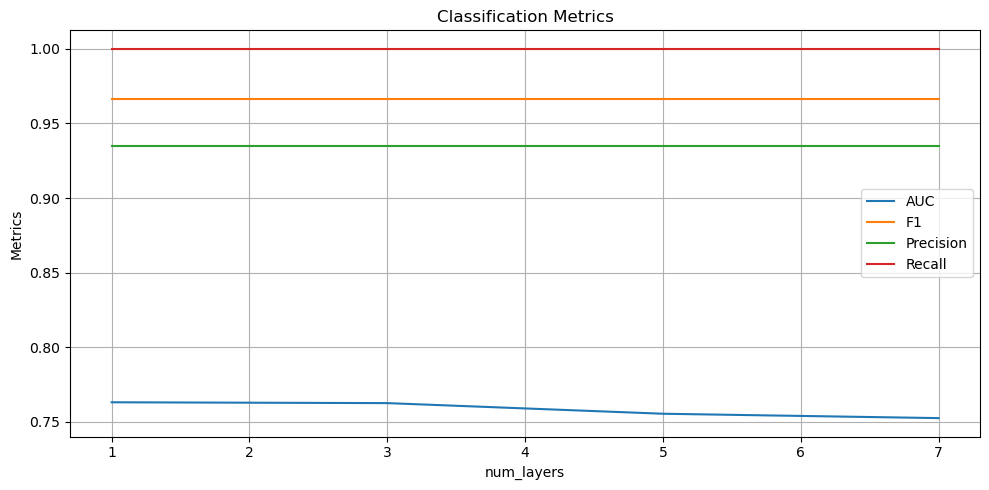

In [6]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Hidden Dimension

In [8]:
data = load_dataset(root=config["data_root"])
metrics = {"auc": [], "accuracy": [],"f1": [], "precision": [], "recall": []}

para_change = "hidden_dim"
para_list = [32, 64, 128, 256, 512]

metrics = hyperparameter_loop(para_change, para_list, metrics)

Using GCN as backbone, with 3 layers.
Epoch 1/10
Avg Batch Loss: 5.313e+02, Avg Batch Attribute Loss: 1.573e+01, Avg Batch Structure Loss: 1.305e+03
Epoch 2/10
Avg Batch Loss: 3.211e+01, Avg Batch Attribute Loss: 1.328e+01, Avg Batch Structure Loss: 6.036e+01
Epoch 3/10
Avg Batch Loss: 1.361e+01, Avg Batch Attribute Loss: 1.273e+01, Avg Batch Structure Loss: 1.493e+01
Epoch 4/10
Avg Batch Loss: 1.048e+01, Avg Batch Attribute Loss: 1.245e+01, Avg Batch Structure Loss: 7.531e+00
Epoch 5/10
Avg Batch Loss: 9.875e+00, Avg Batch Attribute Loss: 1.221e+01, Avg Batch Structure Loss: 6.379e+00
Epoch 6/10
Avg Batch Loss: 9.350e+00, Avg Batch Attribute Loss: 1.208e+01, Avg Batch Structure Loss: 5.255e+00
Epoch 7/10
Avg Batch Loss: 8.990e+00, Avg Batch Attribute Loss: 1.197e+01, Avg Batch Structure Loss: 4.518e+00
Epoch 8/10
Avg Batch Loss: 8.645e+00, Avg Batch Attribute Loss: 1.189e+01, Avg Batch Structure Loss: 3.782e+00
Epoch 9/10
Avg Batch Loss: 8.664e+00, Avg Batch Attribute Loss: 1.181e+01,

Testing: 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]



Test Metrics:
AUC: 0.768
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 9.795e+00
Metrics saved to ./saved_models\test_metrics_None.json
Using GCN as backbone, with 3 layers.
Epoch 1/10
Avg Batch Loss: 6.481e+02, Avg Batch Attribute Loss: 1.591e+01, Avg Batch Structure Loss: 1.596e+03
Epoch 2/10
Avg Batch Loss: 3.379e+01, Avg Batch Attribute Loss: 1.340e+01, Avg Batch Structure Loss: 6.437e+01
Epoch 3/10
Avg Batch Loss: 1.374e+01, Avg Batch Attribute Loss: 1.278e+01, Avg Batch Structure Loss: 1.520e+01
Epoch 4/10
Avg Batch Loss: 1.164e+01, Avg Batch Attribute Loss: 1.243e+01, Avg Batch Structure Loss: 1.046e+01
Epoch 5/10
Avg Batch Loss: 1.028e+01, Avg Batch Attribute Loss: 1.224e+01, Avg Batch Structure Loss: 7.352e+00
Epoch 6/10
Avg Batch Loss: 9.611e+00, Avg Batch Attribute Loss: 1.208e+01, Avg Batch Structure Loss: 5.900e+00
Epoch 7/10
Avg Batch Loss: 9.278e+00, Avg Batch Attribute Loss: 1.199e+01, Avg Batch Structure Loss: 5.216e+00
Epoch 8/10
Avg Batch Loss: 8.94

Testing: 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]



Test Metrics:
AUC: 0.740
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 1.009e+01
Metrics saved to ./saved_models\test_metrics_None.json
Using GCN as backbone, with 3 layers.
Epoch 1/10
Avg Batch Loss: 5.719e+02, Avg Batch Attribute Loss: 1.588e+01, Avg Batch Structure Loss: 1.406e+03
Epoch 2/10
Avg Batch Loss: 3.488e+01, Avg Batch Attribute Loss: 1.337e+01, Avg Batch Structure Loss: 6.715e+01
Epoch 3/10
Avg Batch Loss: 1.385e+01, Avg Batch Attribute Loss: 1.281e+01, Avg Batch Structure Loss: 1.542e+01
Epoch 4/10
Avg Batch Loss: 1.018e+01, Avg Batch Attribute Loss: 1.242e+01, Avg Batch Structure Loss: 6.816e+00
Epoch 5/10
Avg Batch Loss: 9.393e+00, Avg Batch Attribute Loss: 1.221e+01, Avg Batch Structure Loss: 5.165e+00
Epoch 6/10
Avg Batch Loss: 8.955e+00, Avg Batch Attribute Loss: 1.204e+01, Avg Batch Structure Loss: 4.328e+00
Epoch 7/10
Avg Batch Loss: 8.828e+00, Avg Batch Attribute Loss: 1.195e+01, Avg Batch Structure Loss: 4.144e+00
Epoch 8/10
Avg Batch Loss: 8.79

Testing: 100%|██████████| 9/9 [00:05<00:00,  1.50it/s]



Test Metrics:
AUC: 0.769
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 9.490e+00
Metrics saved to ./saved_models\test_metrics_None.json
Using GCN as backbone, with 3 layers.
Epoch 1/10
Avg Batch Loss: 4.440e+02, Avg Batch Attribute Loss: 1.546e+01, Avg Batch Structure Loss: 1.087e+03
Epoch 2/10
Avg Batch Loss: 3.234e+01, Avg Batch Attribute Loss: 1.322e+01, Avg Batch Structure Loss: 6.102e+01
Epoch 3/10
Avg Batch Loss: 1.422e+01, Avg Batch Attribute Loss: 1.266e+01, Avg Batch Structure Loss: 1.655e+01
Epoch 4/10
Avg Batch Loss: 1.085e+01, Avg Batch Attribute Loss: 1.234e+01, Avg Batch Structure Loss: 8.614e+00
Epoch 5/10
Avg Batch Loss: 9.635e+00, Avg Batch Attribute Loss: 1.215e+01, Avg Batch Structure Loss: 5.864e+00
Epoch 6/10
Avg Batch Loss: 9.341e+00, Avg Batch Attribute Loss: 1.201e+01, Avg Batch Structure Loss: 5.343e+00
Epoch 7/10
Avg Batch Loss: 8.979e+00, Avg Batch Attribute Loss: 1.189e+01, Avg Batch Structure Loss: 4.607e+00
Epoch 8/10
Avg Batch Loss: 8.56

Testing: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]



Test Metrics:
AUC: 0.750
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 9.323e+00
Metrics saved to ./saved_models\test_metrics_None.json
Using GCN as backbone, with 3 layers.
Epoch 1/10
Avg Batch Loss: 5.666e+02, Avg Batch Attribute Loss: 1.570e+01, Avg Batch Structure Loss: 1.393e+03
Epoch 2/10
Avg Batch Loss: 3.428e+01, Avg Batch Attribute Loss: 1.334e+01, Avg Batch Structure Loss: 6.569e+01
Epoch 3/10
Avg Batch Loss: 1.412e+01, Avg Batch Attribute Loss: 1.264e+01, Avg Batch Structure Loss: 1.635e+01
Epoch 4/10
Avg Batch Loss: 1.082e+01, Avg Batch Attribute Loss: 1.236e+01, Avg Batch Structure Loss: 8.519e+00
Epoch 5/10
Avg Batch Loss: 1.029e+01, Avg Batch Attribute Loss: 1.217e+01, Avg Batch Structure Loss: 7.484e+00
Epoch 6/10
Avg Batch Loss: 9.365e+00, Avg Batch Attribute Loss: 1.205e+01, Avg Batch Structure Loss: 5.344e+00
Epoch 7/10
Avg Batch Loss: 9.407e+00, Avg Batch Attribute Loss: 1.196e+01, Avg Batch Structure Loss: 5.577e+00
Epoch 8/10
Avg Batch Loss: 8.91

Testing: 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


Test Metrics:
AUC: 0.753
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 1.024e+01
Metrics saved to ./saved_models\test_metrics_None.json


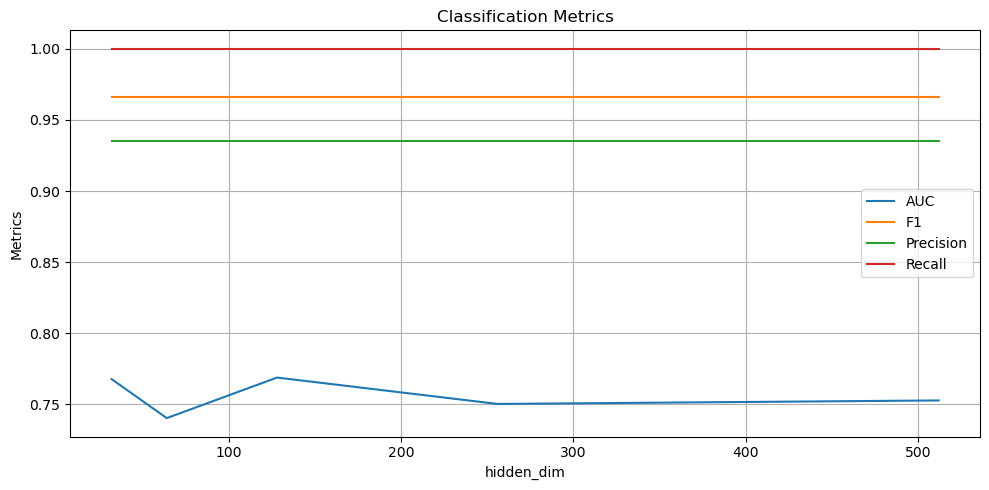

In [9]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Dropout

In [11]:
data = load_dataset(root=config["data_root"])
metrics = {"auc": [], "accuracy": [],"f1": [], "precision": [], "recall": []}

para_change = "dropout"
para_list = [0.0, 0.1, 0.2, 0.3]

metrics = hyperparameter_loop(para_change, para_list, metrics)

Using GCN as backbone, with 3 layers.
Epoch 1/10
Avg Batch Loss: 5.701e+02, Avg Batch Attribute Loss: 1.572e+01, Avg Batch Structure Loss: 1.402e+03
Epoch 2/10
Avg Batch Loss: 3.807e+01, Avg Batch Attribute Loss: 1.348e+01, Avg Batch Structure Loss: 7.497e+01
Epoch 3/10
Avg Batch Loss: 1.434e+01, Avg Batch Attribute Loss: 1.281e+01, Avg Batch Structure Loss: 1.664e+01
Epoch 4/10
Avg Batch Loss: 1.145e+01, Avg Batch Attribute Loss: 1.247e+01, Avg Batch Structure Loss: 9.920e+00
Epoch 5/10
Avg Batch Loss: 1.026e+01, Avg Batch Attribute Loss: 1.225e+01, Avg Batch Structure Loss: 7.270e+00
Epoch 6/10
Avg Batch Loss: 9.560e+00, Avg Batch Attribute Loss: 1.213e+01, Avg Batch Structure Loss: 5.702e+00
Epoch 7/10
Avg Batch Loss: 9.676e+00, Avg Batch Attribute Loss: 1.203e+01, Avg Batch Structure Loss: 6.140e+00
Epoch 8/10
Avg Batch Loss: 9.363e+00, Avg Batch Attribute Loss: 1.195e+01, Avg Batch Structure Loss: 5.477e+00
Epoch 9/10
Avg Batch Loss: 9.142e+00, Avg Batch Attribute Loss: 1.188e+01,

Testing: 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]



Test Metrics:
AUC: 0.759
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 1.102e+01
Metrics saved to ./saved_models\test_metrics_None.json
Using GCN as backbone, with 3 layers.
Epoch 1/10
Avg Batch Loss: 5.921e+02, Avg Batch Attribute Loss: 1.596e+01, Avg Batch Structure Loss: 1.456e+03
Epoch 2/10
Avg Batch Loss: 3.268e+01, Avg Batch Attribute Loss: 1.333e+01, Avg Batch Structure Loss: 6.170e+01
Epoch 3/10
Avg Batch Loss: 1.349e+01, Avg Batch Attribute Loss: 1.279e+01, Avg Batch Structure Loss: 1.454e+01
Epoch 4/10
Avg Batch Loss: 1.027e+01, Avg Batch Attribute Loss: 1.241e+01, Avg Batch Structure Loss: 7.045e+00
Epoch 5/10
Avg Batch Loss: 1.017e+01, Avg Batch Attribute Loss: 1.221e+01, Avg Batch Structure Loss: 7.107e+00
Epoch 6/10
Avg Batch Loss: 9.795e+00, Avg Batch Attribute Loss: 1.210e+01, Avg Batch Structure Loss: 6.341e+00
Epoch 7/10
Avg Batch Loss: 9.041e+00, Avg Batch Attribute Loss: 1.200e+01, Avg Batch Structure Loss: 4.602e+00
Epoch 8/10
Avg Batch Loss: 9.02

Testing: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]



Test Metrics:
AUC: 0.762
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 9.843e+00
Metrics saved to ./saved_models\test_metrics_None.json
Using GCN as backbone, with 3 layers.
Epoch 1/10
Avg Batch Loss: 6.965e+02, Avg Batch Attribute Loss: 1.605e+01, Avg Batch Structure Loss: 1.717e+03
Epoch 2/10
Avg Batch Loss: 3.894e+01, Avg Batch Attribute Loss: 1.358e+01, Avg Batch Structure Loss: 7.699e+01
Epoch 3/10
Avg Batch Loss: 1.446e+01, Avg Batch Attribute Loss: 1.280e+01, Avg Batch Structure Loss: 1.695e+01
Epoch 4/10
Avg Batch Loss: 1.142e+01, Avg Batch Attribute Loss: 1.243e+01, Avg Batch Structure Loss: 9.911e+00
Epoch 5/10
Avg Batch Loss: 1.005e+01, Avg Batch Attribute Loss: 1.220e+01, Avg Batch Structure Loss: 6.812e+00
Epoch 6/10
Avg Batch Loss: 9.745e+00, Avg Batch Attribute Loss: 1.205e+01, Avg Batch Structure Loss: 6.294e+00
Epoch 7/10
Avg Batch Loss: 9.300e+00, Avg Batch Attribute Loss: 1.194e+01, Avg Batch Structure Loss: 5.340e+00
Epoch 8/10
Avg Batch Loss: 9.17

Testing: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]



Test Metrics:
AUC: 0.758
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 1.093e+01
Metrics saved to ./saved_models\test_metrics_None.json
Using GCN as backbone, with 3 layers.
Epoch 1/10
Avg Batch Loss: 6.199e+02, Avg Batch Attribute Loss: 1.573e+01, Avg Batch Structure Loss: 1.526e+03
Epoch 2/10
Avg Batch Loss: 3.996e+01, Avg Batch Attribute Loss: 1.337e+01, Avg Batch Structure Loss: 7.983e+01
Epoch 3/10
Avg Batch Loss: 1.484e+01, Avg Batch Attribute Loss: 1.270e+01, Avg Batch Structure Loss: 1.804e+01
Epoch 4/10
Avg Batch Loss: 1.123e+01, Avg Batch Attribute Loss: 1.237e+01, Avg Batch Structure Loss: 9.526e+00
Epoch 5/10
Avg Batch Loss: 1.055e+01, Avg Batch Attribute Loss: 1.221e+01, Avg Batch Structure Loss: 8.059e+00
Epoch 6/10
Avg Batch Loss: 9.883e+00, Avg Batch Attribute Loss: 1.208e+01, Avg Batch Structure Loss: 6.595e+00
Epoch 7/10
Avg Batch Loss: 9.472e+00, Avg Batch Attribute Loss: 1.198e+01, Avg Batch Structure Loss: 5.706e+00
Epoch 8/10
Avg Batch Loss: 8.90

Testing: 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


Test Metrics:
AUC: 0.747
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 1.099e+01
Metrics saved to ./saved_models\test_metrics_None.json


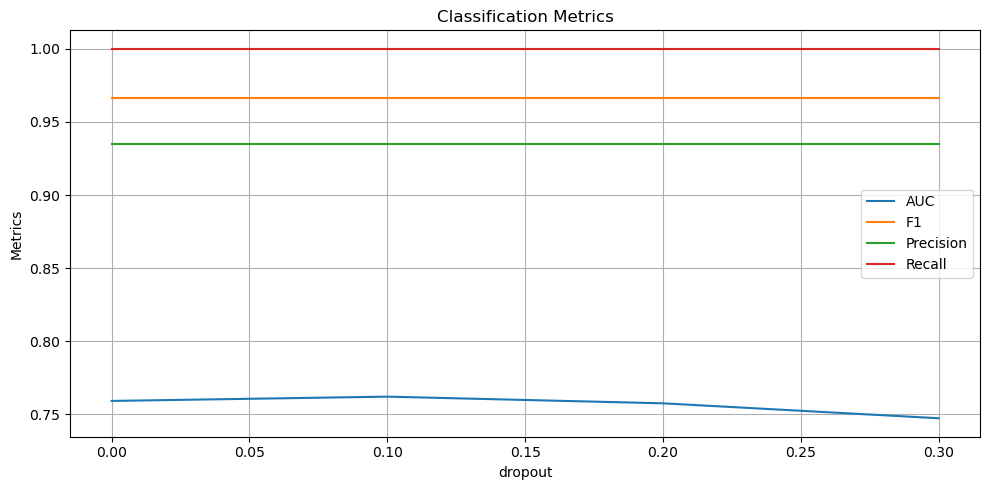

In [12]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Number of neighbors

In [14]:
data = load_dataset(root=config["data_root"])
metrics = {"auc": [], "accuracy": [],"f1": [], "precision": [], "recall": []}

para_change = "num_neighbors"
para_list = [[5,5], [10,10], [15,15], [20,20]]

n_metrics = hyperparameter_loop(para_change, para_list, metrics)

Using GCN as backbone, with 3 layers.
Epoch 1/10
Avg Batch Loss: 6.637e+02, Avg Batch Attribute Loss: 1.581e+01, Avg Batch Structure Loss: 1.636e+03
Epoch 2/10
Avg Batch Loss: 3.754e+01, Avg Batch Attribute Loss: 1.346e+01, Avg Batch Structure Loss: 7.367e+01
Epoch 3/10
Avg Batch Loss: 1.386e+01, Avg Batch Attribute Loss: 1.278e+01, Avg Batch Structure Loss: 1.549e+01
Epoch 4/10
Avg Batch Loss: 1.115e+01, Avg Batch Attribute Loss: 1.244e+01, Avg Batch Structure Loss: 9.223e+00
Epoch 5/10
Avg Batch Loss: 1.045e+01, Avg Batch Attribute Loss: 1.224e+01, Avg Batch Structure Loss: 7.774e+00
Epoch 6/10
Avg Batch Loss: 9.716e+00, Avg Batch Attribute Loss: 1.209e+01, Avg Batch Structure Loss: 6.150e+00
Epoch 7/10
Avg Batch Loss: 9.353e+00, Avg Batch Attribute Loss: 1.200e+01, Avg Batch Structure Loss: 5.386e+00
Epoch 8/10
Avg Batch Loss: 9.170e+00, Avg Batch Attribute Loss: 1.192e+01, Avg Batch Structure Loss: 5.049e+00
Epoch 9/10
Avg Batch Loss: 8.712e+00, Avg Batch Attribute Loss: 1.186e+01,

Testing: 100%|██████████| 9/9 [00:05<00:00,  1.50it/s]



Test Metrics:
AUC: 0.759
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 1.050e+01
Metrics saved to ./saved_models\test_metrics_None.json
Using GCN as backbone, with 3 layers.
Epoch 1/10
Avg Batch Loss: 5.139e+02, Avg Batch Attribute Loss: 1.566e+01, Avg Batch Structure Loss: 1.261e+03
Epoch 2/10
Avg Batch Loss: 3.302e+01, Avg Batch Attribute Loss: 1.335e+01, Avg Batch Structure Loss: 6.252e+01
Epoch 3/10
Avg Batch Loss: 1.393e+01, Avg Batch Attribute Loss: 1.275e+01, Avg Batch Structure Loss: 1.571e+01
Epoch 4/10
Avg Batch Loss: 1.110e+01, Avg Batch Attribute Loss: 1.244e+01, Avg Batch Structure Loss: 9.082e+00
Epoch 5/10
Avg Batch Loss: 1.032e+01, Avg Batch Attribute Loss: 1.224e+01, Avg Batch Structure Loss: 7.434e+00
Epoch 6/10
Avg Batch Loss: 9.700e+00, Avg Batch Attribute Loss: 1.212e+01, Avg Batch Structure Loss: 6.071e+00
Epoch 7/10
Avg Batch Loss: 9.238e+00, Avg Batch Attribute Loss: 1.202e+01, Avg Batch Structure Loss: 5.070e+00
Epoch 8/10
Avg Batch Loss: 8.82

Testing: 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]



Test Metrics:
AUC: 0.758
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 1.024e+01
Metrics saved to ./saved_models\test_metrics_None.json
Using GCN as backbone, with 3 layers.
Epoch 1/10
Avg Batch Loss: 5.722e+02, Avg Batch Attribute Loss: 1.590e+01, Avg Batch Structure Loss: 1.407e+03
Epoch 2/10
Avg Batch Loss: 3.990e+01, Avg Batch Attribute Loss: 1.341e+01, Avg Batch Structure Loss: 7.964e+01
Epoch 3/10
Avg Batch Loss: 1.432e+01, Avg Batch Attribute Loss: 1.275e+01, Avg Batch Structure Loss: 1.668e+01
Epoch 4/10
Avg Batch Loss: 1.110e+01, Avg Batch Attribute Loss: 1.240e+01, Avg Batch Structure Loss: 9.150e+00
Epoch 5/10
Avg Batch Loss: 1.015e+01, Avg Batch Attribute Loss: 1.219e+01, Avg Batch Structure Loss: 7.088e+00
Epoch 6/10
Avg Batch Loss: 9.679e+00, Avg Batch Attribute Loss: 1.206e+01, Avg Batch Structure Loss: 6.108e+00
Epoch 7/10
Avg Batch Loss: 9.476e+00, Avg Batch Attribute Loss: 1.198e+01, Avg Batch Structure Loss: 5.721e+00
Epoch 8/10
Avg Batch Loss: 8.83

Testing: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]



Test Metrics:
AUC: 0.769
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 1.076e+01
Metrics saved to ./saved_models\test_metrics_None.json
Using GCN as backbone, with 3 layers.
Epoch 1/10
Avg Batch Loss: 6.619e+02, Avg Batch Attribute Loss: 1.570e+01, Avg Batch Structure Loss: 1.631e+03
Epoch 2/10
Avg Batch Loss: 4.037e+01, Avg Batch Attribute Loss: 1.331e+01, Avg Batch Structure Loss: 8.095e+01
Epoch 3/10
Avg Batch Loss: 1.438e+01, Avg Batch Attribute Loss: 1.273e+01, Avg Batch Structure Loss: 1.686e+01
Epoch 4/10
Avg Batch Loss: 1.129e+01, Avg Batch Attribute Loss: 1.237e+01, Avg Batch Structure Loss: 9.689e+00
Epoch 5/10
Avg Batch Loss: 1.065e+01, Avg Batch Attribute Loss: 1.219e+01, Avg Batch Structure Loss: 8.349e+00
Epoch 6/10
Avg Batch Loss: 1.022e+01, Avg Batch Attribute Loss: 1.207e+01, Avg Batch Structure Loss: 7.441e+00
Epoch 7/10
Avg Batch Loss: 9.446e+00, Avg Batch Attribute Loss: 1.195e+01, Avg Batch Structure Loss: 5.684e+00
Epoch 8/10
Avg Batch Loss: 9.14

Testing: 100%|██████████| 9/9 [00:05<00:00,  1.50it/s]


Test Metrics:
AUC: 0.764
Accuracy: 0.935
F1: 0.966
Precision: 0.935
Recall: 1.000
Loss: 9.763e+00
Metrics saved to ./saved_models\test_metrics_None.json


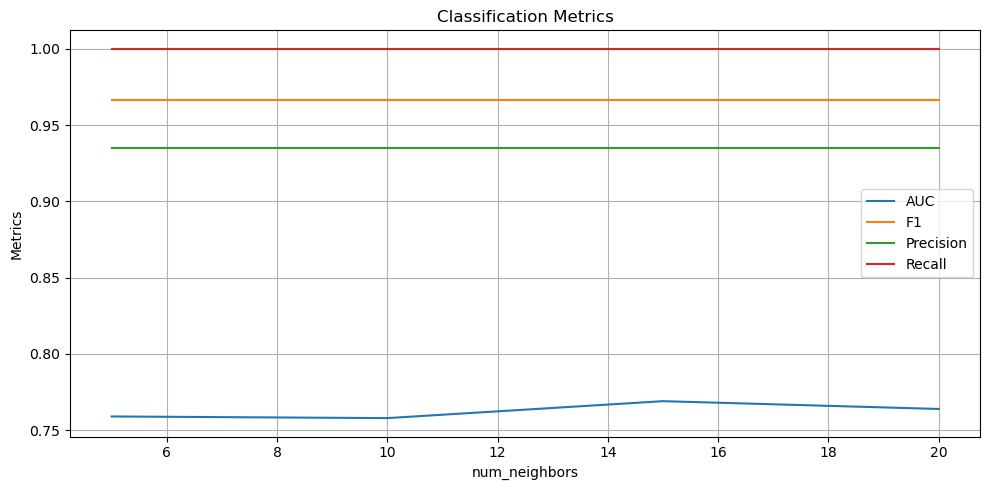

In [15]:
para_list = [5,10,15,20]
plot_metrics(n_metrics, para_list, para_change, x_log=False)